In [1]:
import warnings

import arviz as az
import numpy as np
import pymc3 as pm
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse

In [2]:
az.style.use("arviz-darkgrid")
warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8924
np.random.seed(3264602)

## Generate the observed data from the real distribution

In [3]:
N = 10000

μ_actual = np.array([1.0, -2.0])
sigmas_actual = np.array([0.7, 1.5])
Rho_actual = np.matrix([[1.0, -0.4], [-0.4, 1.0]])

# The real covariance matrix calculated with pre- and post-multiplication
Σ_actual = np.diag(sigmas_actual) * Rho_actual * np.diag(sigmas_actual)

x = np.random.multivariate_normal(μ_actual, Σ_actual, size=N)
Σ_actual

matrix([[ 0.49, -0.42],
        [-0.42,  2.25]])

In [4]:
eigenvalues, unit_eigenvectors = np.linalg.eig(Σ_actual)
print("Eigenvalues {}".format(eigenvalues))
print("Eigenvectors {}".format(unit_eigenvectors))

Eigenvalues [0.39491026 2.34508974]
Eigenvectors [[-0.9753156   0.22081549]
 [-0.22081549 -0.9753156 ]]


In [5]:
sns.color_palette()

[(0.16470588235294117, 0.1803921568627451, 0.9254901960784314),
 (0.9803921568627451, 0.48627450980392156, 0.09019607843137255),
 (0.19607843137254902, 0.5490196078431373, 0.023529411764705882),
 (0.7568627450980392, 0.047058823529411764, 0.5647058823529412),
 (0.5764705882352941, 0.21568627450980393, 0.03137254901960784),
 (0.396078431372549, 0.8980392156862745, 0.9529411764705882),
 (0.9019607843137255, 0.8823529411764706, 0.20784313725490197),
 (0.10980392156862745, 0.803921568627451, 0.41568627450980394),
 (0.7411764705882353, 0.5411764705882353, 0.8352941176470589),
 (0.6941176470588235, 0.4196078431372549, 0.3411764705882353)]

In [6]:
np.sqrt(5.991)

2.4476519360399265

12.756935213767113


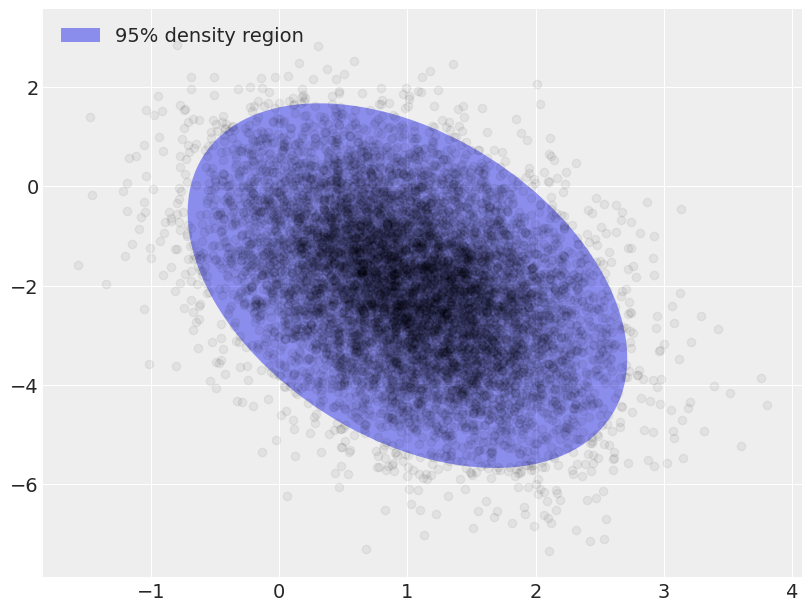

In [7]:
# More info about drawing confidence ellipse for 2D normally distributed data
# https://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/
angle = 180.0 / np.pi * np.arccos(np.abs(unit_eigenvectors[0, 0]))
print(angle)

fig, ax = plt.subplots(figsize=(8, 6))

blue, _, red, *_ = sns.color_palette()

e = Ellipse(μ_actual, 2 * np.sqrt(5.991 * eigenvalues[0]), 2 * np.sqrt(5.991 * eigenvalues[1]), angle=angle)

e.set_alpha(0.5)
e.set_facecolor(blue)
e.set_zorder(10)
ax.add_artist(e)

ax.scatter(x[:, 0], x[:, 1], c="k", alpha=0.05, zorder=11)

rect = plt.Rectangle((0, 0), 1, 1, fc=blue, alpha=0.5)
ax.legend([rect], ["95% density region"], loc=2);

## Modeling the data

LKJ distribution is a prior for the correlation matrix C (not covariance matrix).
If you combine LKJ with priors of the standard deviations of the features x and y, you'll get the covariance matrix Σ.

In [8]:
with pm.Model() as m:
    packed_L = pm.LKJCholeskyCov("packed_L", n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0))

In [9]:
packed_L.tag.test_value.shape

(3,)

In [10]:
with m:
    L = pm.expand_packed_triangular(2, packed_L)
    Σ = L.dot(L.T)

L.tag.test_value.shape

(2, 2)

In [11]:
with pm.Model() as model:
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol", n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )
    cov = pm.Deterministic("cov", chol.dot(chol.T))

In [12]:
with model:
    μ = pm.Normal("μ", 0.0, 1.5, shape=2, testval=x.mean(axis=0))
    obs = pm.MvNormal("obs", μ, chol=chol, observed=x)

In [13]:
with model:
    trace = pm.sample(random_seed=RANDOM_SEED, init="adapt_diag", return_inferencedata=True)
az.summary(trace, var_names=["~chol"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, chol]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
/home/late/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],1.02,0.01,1.00,1.03,0.0,0.0,5675.15,3279.61,1.0
μ[1],-2.03,0.02,-2.06,-2.00,0.0,0.0,5470.64,3447.72,1.0
chol_stds[0],0.69,0.01,0.68,0.70,0.0,0.0,5789.82,3379.11,1.0
chol_stds[1],1.50,0.01,1.48,1.52,0.0,0.0,5876.76,3299.56,1.0
"chol_corr[0,0]",1.00,0.00,1.00,1.00,0.0,0.0,4000.00,4000.00,NaN
"chol_corr[0,1]",-0.39,0.01,-0.41,-0.38,0.0,0.0,5216.02,3420.98,1.0
"chol_corr[1,0]",-0.39,0.01,-0.41,-0.38,0.0,0.0,5216.02,3420.98,1.0
"chol_corr[1,1]",1.00,0.00,1.00,1.00,0.0,0.0,3709.89,3803.07,1.0
"cov[0,0]",0.48,0.01,0.47,0.49,0.0,0.0,5789.82,3379.11,1.0
"cov[0,1]",-0.41,0.01,-0.43,-0.39,0.0,0.0,4595.94,3199.21,1.0


/home/late/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/late/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/late/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/late/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/late/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/late/anaconda3/envs/datascience/lib/pytho

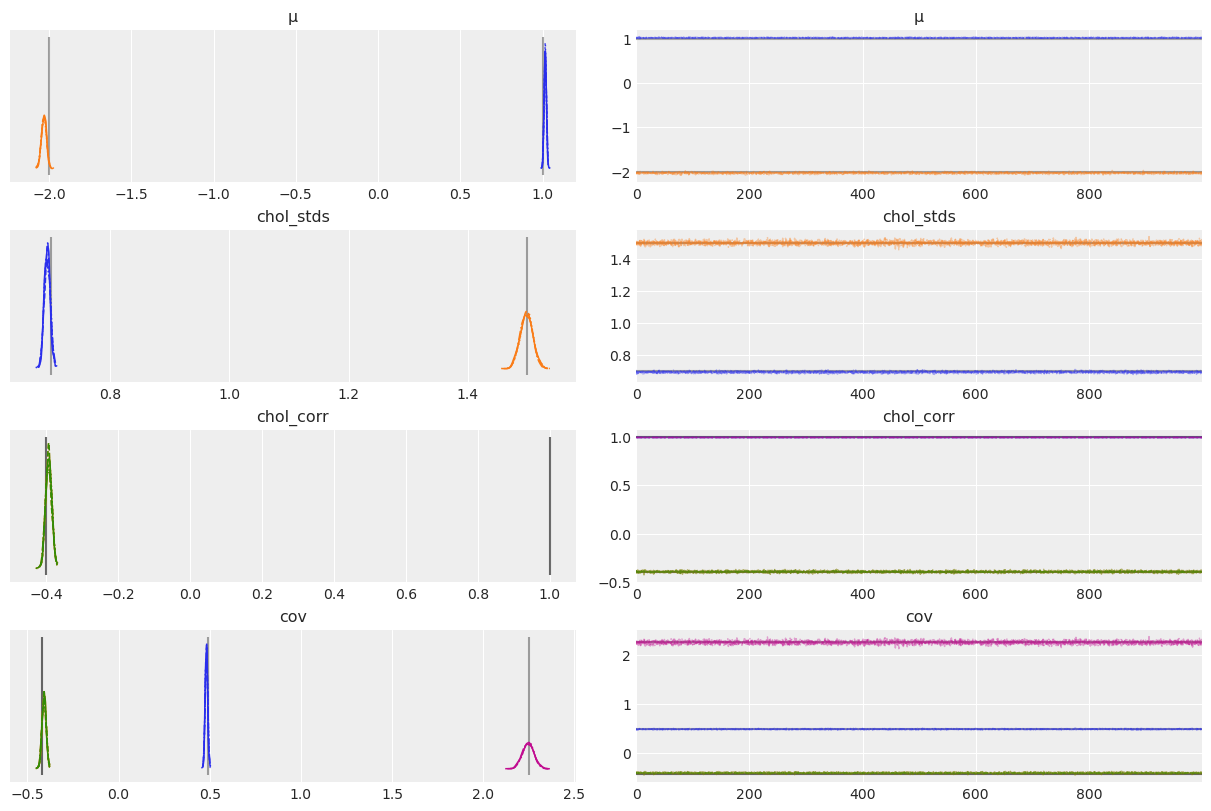

In [14]:
az.plot_trace(
    trace,
    var_names=["~chol"],
    compact=True,
    lines=[
        ("μ", {}, μ_actual),
        ("cov", {}, Σ_actual),
        ("chol_stds", {}, sigmas_actual),
        ("chol_corr", {}, Rho_actual),
    ],
);

In [15]:
μ_post = trace.posterior["μ"].mean(axis=(0, 1)).data
(1 - μ_post / μ_actual).round(2)

array([-0.02, -0.02])

In [16]:
Σ_post = trace.posterior["cov"].mean(axis=(0, 1)).data
(1 - Σ_post / Σ_actual).round(2)

array([[0.02, 0.03],
       [0.03, 0.  ]])

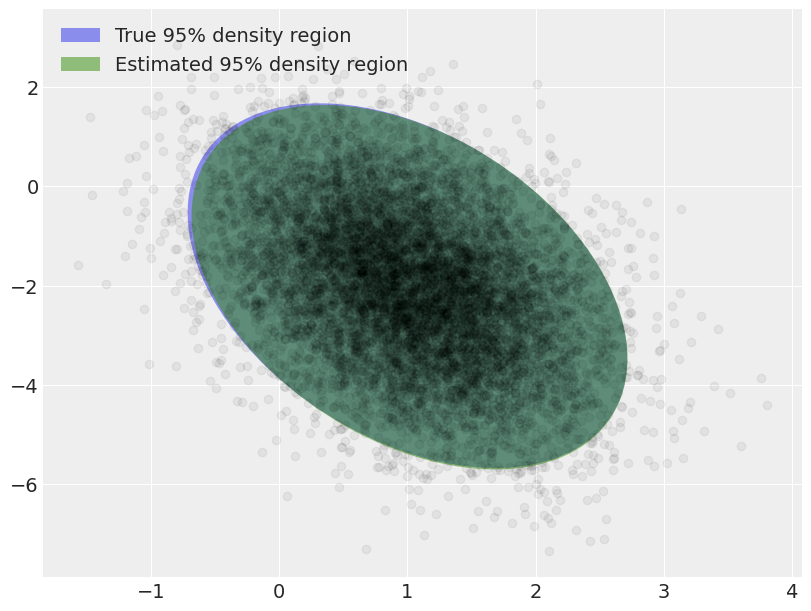

In [18]:
var_post, U_post = np.linalg.eig(Σ_post)
angle_post = 180.0 / np.pi * np.arccos(np.abs(U_post[0, 0]))

fig, ax = plt.subplots(figsize=(8, 6))

e = Ellipse(μ_actual, 2 * np.sqrt(5.991 * eigenvalues[0]), 2 * np.sqrt(5.991 * eigenvalues[1]), angle=angle)
e.set_alpha(0.5)
e.set_facecolor(blue)
e.set_zorder(10)
ax.add_artist(e)

e_post = Ellipse(
    μ_post,
    2 * np.sqrt(5.991 * var_post[0]),
    2 * np.sqrt(5.991 * var_post[1]),
    angle=angle_post,
)
e_post.set_alpha(0.5)
e_post.set_facecolor(red)
e_post.set_zorder(10)
ax.add_artist(e_post)

ax.scatter(x[:, 0], x[:, 1], c="k", alpha=0.05, zorder=11)

rect = plt.Rectangle((0, 0), 1, 1, fc=blue, alpha=0.5)
rect_post = plt.Rectangle((0, 0), 1, 1, fc=red, alpha=0.5)
ax.legend(
    [rect, rect_post],
    ["True 95% density region", "Estimated 95% density region"],
    loc=2,
);